## Train nodule detector with LUNA16 dataset

In [1]:
INPUT_DIR = '../../input/'
OUTPUT_DIR = '../../output/lung-cancer/01/'
IMAGE_DIMS = (50,50,50,1)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.ctscan as ctscan

## Analyse input data

### Let us import annotations

In [3]:
annotations = pd.read_csv(INPUT_DIR + 'annotations.csv')
candidates = pd.read_csv(INPUT_DIR + 'candidates.csv')

In [4]:
print(annotations.iloc[1]['seriesuid'])
print(str(annotations.head()))
annotations.info()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
seriesuid      1186 non-null object
coordX         1186 non-null float64
coordY         1186 non-null float64
coordZ         1186 non-null float64
diameter_mm    1186 non-nul

In [5]:
print(candidates.iloc[1]['seriesuid'])
print(str(candidates.head()))
candidates.info()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
                                           seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 -286.62   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -33.66  -72.75 -308.41   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -32.25  -85.36 -362.51   

   class  
0      0  
1      0  
2      0  
3      0  
4      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
seriesuid    551065 non-null object
coordX       551065 non-null float64
coordY       551065 non-null float64
coordZ       551065 non-null float64
class        551065 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [6]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


### Lets take a look at some images

In [7]:
scan = ctscan.CTScanMhd(INPUT_DIR, '1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058')

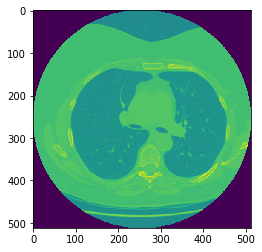

In [8]:
pixels = scan.get_image()
plt.imshow(pixels[80])

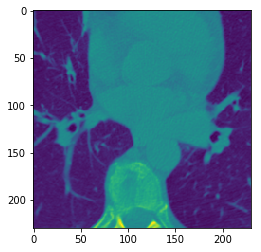

In [9]:
pixels = scan.get_subimage((40,40,10), (230,230,230))
plt.imshow(pixels[40])

### Classes are heaviliy unbalanced, hardly 0.2% percent are positive.

The best way to move forward will be to undersample the negative class and then augment the positive class heaviliy to balance out the samples.

#### Plan of attack:

1. Get an initial subsample of negative class and keep all of the positives such that we have a 80/20 class distribution

2. Create a training set such that we augment minority class heavilby rotating to get a 50/50 class distribution

In [10]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

###  Ok the class to get image data works

Next thing to do is to undersample negative class drastically. Since the number of positives in the data set of 551065 are 1351 and rest are negatives, I plan to make the dataset less skewed. Like a 70%/30% split.

In [11]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [12]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)
print(len(positives))
print(len(negIndexes))

1351
6755


In [13]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

## Prepare input data

### Split into test train set 

In [14]:
from sklearn.cross_validation import train_test_split
X = candidatesDf.iloc[:,:-1]
Y = candidatesDf.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
#print(str(X_test))
#print(str(Y_test))

### Create a validation dataset

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 42)

In [17]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

5187
1297
1622


In [18]:
print('number of positive cases are ' + str(Y_train.sum()))
print('total set size is ' + str(len(Y_train)))
print('percentage of positive cases are ' + str(Y_train.sum()*1.0/len(Y_train)))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817


### We will need to augment the positive dataset like mad! Add new keys to X_train and Y_train for augmented data

In [19]:
tempDf = X_train[Y_train == 1]
tempDf = tempDf.set_index(X_train[Y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[Y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = Y_train.reindex(X_train[Y_train == 1].index + 1000000)
ytemp.loc[:] = 1
Y_train_new = Y_train.append(ytemp)
ytemp = Y_train.reindex(X_train[Y_train == 1].index + 2000000)
ytemp.loc[:] = 1
Y_train_new = Y_train_new.append(ytemp)

X_train = X_train_new
Y_train = Y_train_new
print(len(X_train), len(Y_train))

6877 6877


In [20]:
print('After undersampling')
print('number of positive cases are ' + str(Y_train.sum()))
print('total set size is ' + str(len(Y_train)))
print('percentage of positive cases are ' + str(Y_train.sum()*1.0/len(Y_train)))

After undersampling
number of positive cases are 2535.0
total set size is 6877
percentage of positive cases are 0.368620037807


In [21]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(X_train.head())
print(Y_train.head())

6877
1297
1622
                                                seriesuid      coordX  \
59270   1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...  -97.808167   
150277  1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...   58.990000   
432208  1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...  -50.307219   
423122  1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295... -106.731000   
344581  1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...   67.240000   

            coordY      coordZ  
59270     3.897917 -201.030000  
150277  -24.230000  -18.320000  
432208  159.439740 -113.418797  
423122 -104.468000  751.163333  
344581  -32.590000 -107.790000  
59270     0.0
150277    0.0
432208    0.0
423122    0.0
344581    0.0
Name: class, dtype: float64


### Prepare output dir

In [22]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-03-24 12:04:10,659 INFO Dir ../../output/lung-cancer/01/ created


### Create HDF5 dataset with input data

In [23]:
def create_dataset(file_path, x_data, y_data):
    logger.info('Creating dataset ' + file_path + ' size=' + str(len(x_data)))
    file_path_tmp = file_path + '.tmp'
    with h5py.File(file_path_tmp, 'w') as h5f:
        x_ds = h5f.create_dataset('X', (len(x_data), IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2], IMAGE_DIMS[3]), chunks=(1, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2], IMAGE_DIMS[3]), dtype='f')
        y_ds = h5f.create_dataset('Y', (len(y_data), 2), dtype='f')
        valid = []
        for c, idx in enumerate(x_data.index):
            #if(c>3): break
            d = x_data.loc[idx]
            filename = d[0]
            t = Timer('Loading scan ' + str(filename))
            scan = ctscan.CTScanMhd(INPUT_DIR, filename)
            pixels = scan.get_subimage((d[3],d[2],d[1]), IMAGE_DIMS)
            #add color channel dimension
            pixels = np.expand_dims(pixels, axis=3)
            #plt.imshow(pixels[round(np.shape(pixels)[0]/2),:,:,0])
            #plt.show()
            if(np.shape(pixels) == (50,50,50,1)):
                x_ds[c] = pixels
                y_ds[c] = [1,0]
                if(y_data.loc[idx] == 1):
                    y_ds[c] = [0,1]
                valid.append(c)
            else:
                logger.warning('Invalid shape detected in image. Skipping. ' + str(np.shape(pixels)))
            t.stop()

    #dump only valid entries to dataset file
    c = 0
    with h5py.File(file_path, 'w') as h5fw:
        x_dsw = h5fw.create_dataset('X', (len(valid), IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2], IMAGE_DIMS[3]), chunks=(1, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2], IMAGE_DIMS[3]), dtype='f')
        y_dsw = h5fw.create_dataset('Y', (len(valid), 2), dtype='f')
        with h5py.File(file_path_tmp, 'r') as h5fr:
            x_dsr = h5fr['X']
            y_dsr = h5fr['Y']
            for i in range(len(x_dsr)):
                if(i in valid):
                    x_dsw[c] = x_dsr[i]
                    y_dsw[c] = y_dsr[i]
                    c = c + 1

    os.remove(file_path_tmp)
            
    utils.validate_xy_dataset(file_path, save_dir=OUTPUT_DIR + 'samples/')

In [24]:
#create_dataset(OUTPUT_DIR + 'nodules-train.h5', X_train, Y_train)

In [ ]:
#create_dataset(OUTPUT_DIR + 'nodules-validate.h5', X_val, Y_val)

In [ ]:
create_dataset(OUTPUT_DIR + 'nodules-test.h5', X_test, Y_test)

2017-03-24 12:04:10,732 INFO Creating dataset ../../output/lung-cancer/01/nodules-test.h5 size=1622
2017-03-24 12:04:10,742 INFO > [started] Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227...
2017-03-24 12:04:11,289 INFO > [done]    Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227 (547.023 ms)
2017-03-24 12:04:11,291 INFO > [started] Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329...
2017-03-24 12:04:12,987 INFO > [done]    Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329 (1695.735 ms)
2017-03-24 12:04:12,989 INFO > [started] Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.118140393257625250121502185026...
2017-03-24 12:04:14,472 INFO > [done]    Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.118140393257625250121502185026 (1482.664 ms)
2017-03-24 12:04:14,475 INFO > [started] Loading scan 1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111...
2017-03-24 12:

0[ 1.  0.]


2017-03-24 13:00:13,746 INFO y=[ 1.  0.]
2017-03-24 13:00:13,748 INFO image_index 524
2017-03-24 13:00:13,749 INFO x=


1[ 1.  0.]


2017-03-24 13:00:15,047 INFO y=[ 1.  0.]
2017-03-24 13:00:15,048 INFO image_index 1049
2017-03-24 13:00:15,050 INFO x=


2[ 1.  0.]


2017-03-24 13:00:16,532 INFO y=[ 1.  0.]
